In [1]:
!pip install transformers sentencepiece -q
!pip install hazm -q
import pandas as pd
import re
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import itertools


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
Using device: cpu


In [2]:
data = pd.read_csv("/content/emails.csv")

if 'label' not in data.columns:
    raise ValueError("The 'label' column is missing in the dataset.")

persian_stop_words = {
    "و", "به", "از", "در", "که", "این", "را", "برای", "است", "می",
    "با", "آن", "او", "ها", "یا", "هر", "هم", "ما", "شما", "آنها",
    "اگر", "چون", "همین", "یک", "تا"
}

def remove_url(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_email(text):
    return re.sub(r'\S+@\S+', '', text)

def remove_phone(text):
    return re.sub(r'\b\d{10,}\b', '', text)

def remove_repetition(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_stop_words(text, stopwords):
    return ' '.join([word for word in text.split() if word not in stopwords])

data['text_clean'] = data['text'].apply(remove_url)
data['text_clean'] = data['text_clean'].apply(remove_email)
data['text_clean'] = data['text_clean'].apply(remove_phone)
data['text_clean'] = data['text_clean'].apply(remove_repetition)
data['text_clean'] = data['text_clean'].apply(lambda x: remove_stop_words(x, persian_stop_words))

le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['label'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'ham': 0, 'spam': 1}


In [3]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model.to(device)
model.eval()

def tokenize_and_pad(texts, max_length=32):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return tokens

def generate_embedding(tokenized_data):
    with torch.no_grad():
        inputs = {key: val.to(device) for key, val in tokenized_data.items()}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings.cpu().numpy()

def reduce_dim(embeddings, n_components=120):
    pca = PCA(n_components=n_components, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

tokenized_data = tokenize_and_pad(data['text_clean'].tolist(), max_length=32)
embeddings = generate_embedding(tokenized_data)
reduced_embeddings = reduce_dim(embeddings, n_components=120)

X = reduced_embeddings
y = data['label_encoded']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [11]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, dropout=0.3, num_filters=128, kernel_size=3):
        super(CNNLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters),
            nn.MaxPool1d(kernel_size=2)
        )

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)

        lstm_out, (hidden, cell) = self.lstm(x)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=25):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                outputs = model(batch_x)
                preds = outputs.cpu().numpy()
                val_preds.extend(preds)
                val_targets.extend(batch_y.numpy())

        val_preds_binary = [1 if p >= 0.5 else 0 for p in val_preds]
        accuracy = accuracy_score(val_targets, val_preds_binary)
        print(f"Epoch {epoch+1}/{epochs} - Validation Accuracy: {accuracy:.4f}")

    return model


def evaluate_model(model, data_loader):
    model.eval()
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = outputs.cpu().numpy()
            test_preds.extend(preds)
            test_targets.extend(batch_y.numpy())

    test_preds_binary = [1 if p >= 0.5 else 0 for p in test_preds]
    accuracy = accuracy_score(test_targets, test_preds_binary)
    precision = precision_score(test_targets, test_preds_binary, zero_division=0)
    recall = recall_score(test_targets, test_preds_binary, zero_division=0)
    f1 = f1_score(test_targets, test_preds_binary, zero_division=0)
    roc_auc = roc_auc_score(test_targets, test_preds)

    return accuracy, precision, recall, f1, roc_auc

In [13]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, dropout=0.3, num_filters=128, kernel_size=3):
        super(CNNLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters),
            nn.MaxPool1d(kernel_size=2)
        )

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        lstm_out, (hidden, cell) = self.lstm(x)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                outputs = model(batch_x)
                preds = outputs.cpu().numpy()
                val_preds.extend(preds)
                val_targets.extend(batch_y.numpy())

        val_preds_binary = [1 if p >= 0.5 else 0 for p in val_preds]
        accuracy = accuracy_score(val_targets, val_preds_binary)
        print(f"Epoch {epoch+1}/{epochs} - Validation Accuracy: {accuracy:.4f}")

    return model


def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = outputs.cpu().numpy()
            test_preds.extend(preds)
            test_targets.extend(batch_y.numpy())

    test_preds_binary = [1 if p >= 0.5 else 0 for p in test_preds]
    accuracy = accuracy_score(test_targets, test_preds_binary)
    precision = precision_score(test_targets, test_preds_binary, zero_division=0)
    recall = recall_score(test_targets, test_preds_binary, zero_division=0)
    f1 = f1_score(test_targets, test_preds_binary, zero_division=0)
    roc_auc = roc_auc_score(test_targets, test_preds)
    return accuracy, precision, recall, f1, roc_auc


criterion = nn.BCELoss()

def test_hyperparams(model_class, param_name, param_values, fixed_params, train_dataset, val_dataset, epochs=10, device='cpu'):
    best_acc = 0
    best_val = None
    best_state = None

    for val in param_values:
        temp_params = fixed_params.copy()
        temp_params[param_name] = val

        train_loader = DataLoader(train_dataset, batch_size=temp_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=temp_params['batch_size'], shuffle=False)

        model = model_class(input_dim=120)
        if temp_params['optimizer'] == 'Adam':
            optimizer_model = optim.Adam(model.parameters(), lr=temp_params['learning_rate'])
        else:
            optimizer_model = optim.SGD(model.parameters(), lr=temp_params['learning_rate'])

        print(f"Testing {param_name}={val}, batch_size={temp_params['batch_size']}, "
              f"lr={temp_params['learning_rate']}, optimizer={temp_params['optimizer']}")

        trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer_model, epochs=epochs, device=device)

        val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = evaluate_model(trained_model, val_loader, device=device)
        print(f"Final Metrics for {param_name}={val}:")
        print(f"Accuracy: {val_accuracy:.4f}")
        print(f"Precision: {val_precision:.4f}")
        print(f"Recall: {val_recall:.4f}")
        print(f"F1-Score: {val_f1:.4f}")
        print(f"ROC AUC: {val_roc_auc:.4f}\n")

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_val = val
            best_state = trained_model.state_dict()

    return best_val, best_acc, best_state


batch_sizes = [8, 16, 32, 64]
learning_rates = [0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001]
optimizers_list = ['Adam', 'SGD']


print("Step 1: Finding best batch size...")
best_bsz, best_acc_bsz, best_bsz_state = test_hyperparams(
    model_class=CNNLSTM,
    param_name='batch_size',
    param_values=batch_sizes,
    fixed_params=fixed_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=10,
    device=device
)
fixed_params['batch_size'] = best_bsz
print(f"Best Batch Size: {best_bsz}, Accuracy: {best_acc_bsz:.4f}\n")

print("Step 2: Finding best learning rate...")
best_lr, best_acc_lr, best_lr_state = test_hyperparams(
    model_class=CNNLSTM,
    param_name='learning_rate',
    param_values=learning_rates,
    fixed_params=fixed_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=10,
    device=device
)
fixed_params['learning_rate'] = best_lr
print(f"Best Learning Rate: {best_lr}, Accuracy: {best_acc_lr:.4f}\n")

print("Step 3: Finding best optimizer...")
best_opt, best_acc_opt, best_opt_state = test_hyperparams(
    model_class=CNNLSTM,
    param_name='optimizer',
    param_values=optimizers_list,
    fixed_params=fixed_params,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=10,
    device=device
)
fixed_params['optimizer'] = best_opt
print(f"Best Optimizer: {best_opt}, Accuracy: {best_acc_opt:.4f}\n")

print("Best Hyperparameters found via greedy search:")
print(f"Batch Size: {fixed_params['batch_size']}")
print(f"Learning Rate: {fixed_params['learning_rate']}")
print(f"Optimizer: {fixed_params['optimizer']}")


Step 1: Finding best batch size...
Testing batch_size=8, batch_size=8, lr=0.001, optimizer=Adam
Epoch 1/10 - Validation Accuracy: 0.9714
Epoch 2/10 - Validation Accuracy: 0.9786
Epoch 3/10 - Validation Accuracy: 0.9714
Epoch 4/10 - Validation Accuracy: 0.9786
Epoch 5/10 - Validation Accuracy: 0.9643
Epoch 6/10 - Validation Accuracy: 0.9643
Epoch 7/10 - Validation Accuracy: 0.9571
Epoch 8/10 - Validation Accuracy: 0.9500
Epoch 9/10 - Validation Accuracy: 0.9571
Epoch 10/10 - Validation Accuracy: 0.9643
Final Metrics for batch_size=8:
Accuracy: 0.9643
Precision: 0.9577
Recall: 0.9714
F1-Score: 0.9645
ROC AUC: 0.9947

Testing batch_size=16, batch_size=16, lr=0.001, optimizer=Adam
Epoch 1/10 - Validation Accuracy: 0.9571
Epoch 2/10 - Validation Accuracy: 0.9714
Epoch 3/10 - Validation Accuracy: 0.9714
Epoch 4/10 - Validation Accuracy: 0.9714
Epoch 5/10 - Validation Accuracy: 0.9714
Epoch 6/10 - Validation Accuracy: 0.9643
Epoch 7/10 - Validation Accuracy: 0.9714
Epoch 8/10 - Validation Acc

In [15]:
final_cnnlstm = CNNLSTM(input_dim=120)
final_cnnlstm.load_state_dict(best_opt_state)

if fixed_params['optimizer'] == 'Adam':
    optimizer_final = optim.Adam(final_cnnlstm.parameters(), lr=fixed_params['learning_rate'])
else:
    optimizer_final = optim.SGD(final_cnnlstm.parameters(), lr=fixed_params['learning_rate'])

train_loader = DataLoader(train_dataset, batch_size=fixed_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=fixed_params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=fixed_params['batch_size'], shuffle=False)

print("Training final CNN-LSTM model with chosen hyperparameters...")
final_cnnlstm = train_and_evaluate(final_cnnlstm, train_loader, val_loader, criterion, optimizer_final, epochs=25)

train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = evaluate_model(final_cnnlstm, train_loader)
print("\nFinal CNN-LSTM Training Set Evaluation:")
print(f"Accuracy: {train_accuracy:.6f}")
print(f"Precision: {train_precision:.6f}")
print(f"Recall: {train_recall:.6f}")
print(f"F1-Score: {train_f1:.6f}")
print(f"ROC AUC: {train_roc_auc:.6f}")

val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = evaluate_model(final_cnnlstm, val_loader)
print("\nFinal CNN-LSTM Validation Set Evaluation:")
print(f"Accuracy: {val_accuracy:.6f}")
print(f"Precision: {val_precision:.6f}")
print(f"Recall: {val_recall:.6f}")
print(f"F1-Score: {val_f1:.6f}")
print(f"ROC AUC: {val_roc_auc:.6f}")

test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = evaluate_model(final_cnnlstm, test_loader)
print("\nFinal CNN-LSTM Test Set Evaluation:")
print(f"Accuracy: {test_accuracy:.6f}")
print(f"Precision: {test_precision:.6f}")
print(f"Recall: {test_recall:.6f}")
print(f"F1-Score: {test_f1:.6f}")
print(f"ROC AUC: {test_roc_auc:.6f}")


Training final CNN-LSTM model with chosen hyperparameters...
Epoch 1/25 - Validation Accuracy: 0.9643
Epoch 2/25 - Validation Accuracy: 0.9643
Epoch 3/25 - Validation Accuracy: 0.9643
Epoch 4/25 - Validation Accuracy: 0.9643
Epoch 5/25 - Validation Accuracy: 0.9714
Epoch 6/25 - Validation Accuracy: 0.9714
Epoch 7/25 - Validation Accuracy: 0.9714
Epoch 8/25 - Validation Accuracy: 0.9643
Epoch 9/25 - Validation Accuracy: 0.9714
Epoch 10/25 - Validation Accuracy: 0.9714
Epoch 11/25 - Validation Accuracy: 0.9714
Epoch 12/25 - Validation Accuracy: 0.9714
Epoch 13/25 - Validation Accuracy: 0.9714
Epoch 14/25 - Validation Accuracy: 0.9714
Epoch 15/25 - Validation Accuracy: 0.9714
Epoch 16/25 - Validation Accuracy: 0.9714
Epoch 17/25 - Validation Accuracy: 0.9643
Epoch 18/25 - Validation Accuracy: 0.9643
Epoch 19/25 - Validation Accuracy: 0.9714
Epoch 20/25 - Validation Accuracy: 0.9714
Epoch 21/25 - Validation Accuracy: 0.9714
Epoch 22/25 - Validation Accuracy: 0.9714
Epoch 23/25 - Validation

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(SimpleCNN, self).__init__()
        self.cnn = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear((input_dim // 2) * 100, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, (hidden, cell) = self.lstm(x)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Train Simple CNN
simple_cnn = SimpleCNN(input_dim=120)
if fixed_params['optimizer'] == 'Adam':
    optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=fixed_params['learning_rate'])
else:
    optimizer_cnn = optim.SGD(simple_cnn.parameters(), lr=fixed_params['learning_rate'])

print("\nTraining Simple CNN model...")
simple_cnn = train_and_evaluate(simple_cnn, train_loader, val_loader, criterion, optimizer_cnn, epochs=25)
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_roc_auc = evaluate_model(simple_cnn, test_loader)
print("Simple CNN Test Set Evaluation:")
print(f"Accuracy: {cnn_accuracy:.6f}")
print(f"Precision: {cnn_precision:.6f}")
print(f"Recall: {cnn_recall:.6f}")
print(f"F1-Score: {cnn_f1:.6f}")
print(f"ROC AUC: {cnn_roc_auc:.6f}")

# Train Simple LSTM
simple_lstm = SimpleLSTM(input_dim=120)
if fixed_params['optimizer'] == 'Adam':
    optimizer_lstm = optim.Adam(simple_lstm.parameters(), lr=fixed_params['learning_rate'])
else:
    optimizer_lstm = optim.SGD(simple_lstm.parameters(), lr=fixed_params['learning_rate'])

print("\nTraining Simple LSTM model...")
simple_lstm = train_and_evaluate(simple_lstm, train_loader, val_loader, criterion, optimizer_lstm, epochs=25)
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_roc_auc = evaluate_model(simple_lstm, test_loader)
print("Simple LSTM Test Set Evaluation:")
print(f"Accuracy: {lstm_accuracy:.6f}")
print(f"Precision: {lstm_precision:.6f}")
print(f"Recall: {lstm_recall:.6f}")
print(f"F1-Score: {lstm_f1:.6f}")
print(f"ROC AUC: {lstm_roc_auc:.6f}")


Training Simple CNN model...
Epoch 1/25 - Validation Accuracy: 0.9071
Epoch 2/25 - Validation Accuracy: 0.9571
Epoch 3/25 - Validation Accuracy: 0.9500
Epoch 4/25 - Validation Accuracy: 0.9643
Epoch 5/25 - Validation Accuracy: 0.9571
Epoch 6/25 - Validation Accuracy: 0.9786
Epoch 7/25 - Validation Accuracy: 0.9643
Epoch 8/25 - Validation Accuracy: 0.9786
Epoch 9/25 - Validation Accuracy: 0.9643
Epoch 10/25 - Validation Accuracy: 0.9714
Epoch 11/25 - Validation Accuracy: 0.9714
Epoch 12/25 - Validation Accuracy: 0.9714
Epoch 13/25 - Validation Accuracy: 0.9714
Epoch 14/25 - Validation Accuracy: 0.9714
Epoch 15/25 - Validation Accuracy: 0.9714
Epoch 16/25 - Validation Accuracy: 0.9786
Epoch 17/25 - Validation Accuracy: 0.9714
Epoch 18/25 - Validation Accuracy: 0.9786
Epoch 19/25 - Validation Accuracy: 0.9786
Epoch 20/25 - Validation Accuracy: 0.9714
Epoch 21/25 - Validation Accuracy: 0.9786
Epoch 22/25 - Validation Accuracy: 0.9714
Epoch 23/25 - Validation Accuracy: 0.9571
Epoch 24/25 -

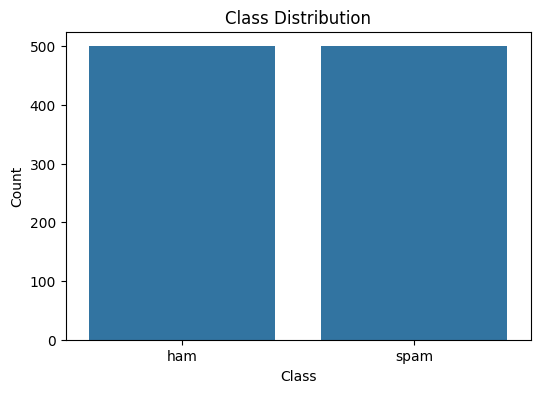

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_bow_text = data['text_clean']
y_bow = data['label_encoded']

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow_text, y_bow, test_size=0.3, random_state=42, stratify=y_bow
)

vectorizer = CountVectorizer()
X_train_bow_vec = vectorizer.fit_transform(X_train_bow)
X_test_bow_vec = vectorizer.transform(X_test_bow)

models = {
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results_bow = []

for model_name, model in models.items():
    model.fit(X_train_bow_vec, y_train_bow)
    y_pred = model.predict(X_test_bow_vec)
    y_prob = model.predict_proba(X_test_bow_vec)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test_bow, y_pred)
    precision = precision_score(y_test_bow, y_pred, zero_division=0)
    recall = recall_score(y_test_bow, y_pred, zero_division=0)
    f1 = f1_score(y_test_bow, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_bow, y_prob) if y_prob is not None else None

    results_bow.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

results_bow_df = pd.DataFrame(results_bow)

print("Evaluation Results for Traditional ML Models using BoW:")
print(results_bow_df)

Evaluation Results for Traditional ML Models using BoW:
           Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0            SVM  0.900000   0.968750  0.826667  0.892086  0.980000
1            KNN  0.843333   0.990476  0.693333  0.815686  0.950911
2  Decision Tree  0.900000   0.922535  0.873333  0.897260  0.900000
3  Random Forest  0.953333   1.000000  0.906667  0.951049  0.991244
